<a href="https://colab.research.google.com/github/baroodb/code/blob/main/cbir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
PROJECT = 'my-third-project-326309'
LOCATION = 'gs://baroo_bucket'
MODEL_PATH="${LOCATION}/Encoder"

In [5]:
!echo $MODEL_PATH/stop

/Encoder/stop


In [6]:
import os
os.environ['LOCATION']=LOCATION
os.environ['TEST']='hello'

In [7]:
!gcloud config set project $PROJECT

Updated property [core/project].


In [10]:
%%bash
echo "${LOCATION}/Encoder"

gs://baroo_bucket/Encoder


In [11]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2


In [12]:
args = {
	"model": "output/autoencoder",
	"vis": "recon_vis.png",
	"plot": "plot.png"
}

In [ ]:
%%bash
gsutil cp -r output/autoencoder $LOCATION/Encoder/saved_model

In [13]:
!gsutil ls $LOCATION/Encoder/saved_model

gs://baroo_bucket/Encoder/saved_model/keras_metadata.pb
gs://baroo_bucket/Encoder/saved_model/saved_model.pb
gs://baroo_bucket/Encoder/saved_model/variables/


In [14]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim, name="encoded")(x)

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		x = Dense(np.prod(volumeSize[1:]))(latent)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid", name="decoded")(x)

		# construct our autoencoder model
		autoencoder = Model(inputs, outputs, name="autoencoder")

		# return the autoencoder model
		return autoencoder

In [18]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0



[INFO] loading MNIST dataset...
11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
autoencoder = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

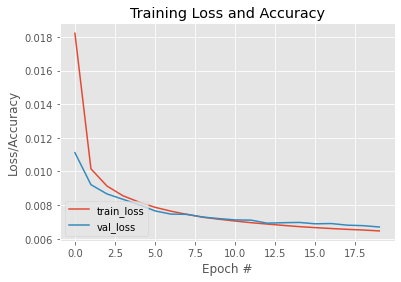

In [ ]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()

In [ ]:
# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder.save(args["model"])

[INFO] saving autoencoder...
INFO:tensorflow:Assets written to: output/autoencoder/assets


In [ ]:
# use the convolutional autoencoder to make predictions on the
# testing images, construct the visualization, and then save it
# to disk
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2.imwrite(args["vis"], vis)

In [15]:
model_files = os.path.join(LOCATION, 'Encoder/saved_model')
model_files

'gs://baroo_bucket/Encoder/saved_model'

In [16]:
model = load_model(model_files)

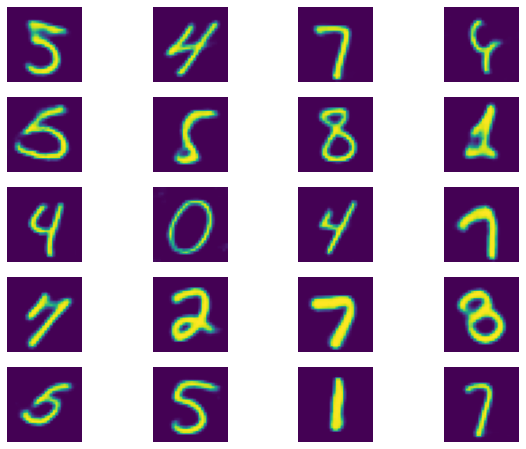

In [19]:
plt.figure(figsize=(10, 8))
def print_some_preds(data):
  preds = model.predict(data)
  choices = np.random.choice(len(preds), size=(20))
  for i in range(len(choices)):
    plt.subplot(5, 4, i+1)
    image = (preds[choices[i]]* 255.0).astype('uint8')
    plt.imshow(np.squeeze(image))
    plt.axis('off')
  return preds

preds = print_some_preds(testX)

In [33]:
args = {
    "model": "output/autoencoder"
}

In [20]:
# move to the CBIR part 
def encode_images(images, output_path):
  '''This function encode the data and saves it to pickle'''
  encoder = Model(inputs=model.inputs, outputs=model.get_layer('encoded').output)

  images_encoded = encoder.predict(images)
  indexes = list(range(len(images_encoded)))

  data = {
      "Indexes": indexes,
      "Images": images_encoded
  }

  print('Saving the pickle file to disk')
  with open(output_path, 'wb') as f:
    f.write(pickle.dumps(data))

In [21]:
enc_path = os.path.join(LOCATION, 'Encoder/encoded.pickle')
print(f'Peparing to send the data to {enc_path}')

encode_images(trainX, 'index.pickle')

Peparing to send the data to gs://baroo_bucket/Encoder/encoded.pickle
Saving the pickle file to disk


In [27]:
f = open('index.pickle', 'rb')
d = pickle.loads(f.read())
d.get('Images').shape

(60000, 16)

In [65]:
def euclidean(a, b):
	# compute and return the euclidean distance between two vectors
	return np.linalg.norm(a - b)
 

def perform_search(features, index, n_closest):
  
  results = []

  for i in range(len(index.get('Images'))):
    d = euclidean(features, index.get('Images')[i])
    results.append((d, i))
  
  return sorted(results)[:n_closest]



In [47]:
random_id = np.random.choice(list(range(len(testX))))
random_id

2086

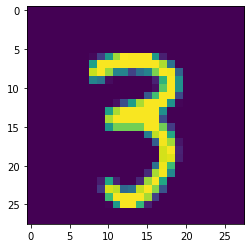

In [48]:
random_image = testX[random_id]
plt.imshow(np.squeeze(random_image))

In [67]:
encoder = Model(inputs=model.inputs, outputs=model.get_layer('encoded').output)
features = encoder.predict(np.expand_dims(random_image, axis=0))

index = pickle.loads(open('index.pickle', 'rb').read())
results = perform_search(features, index, 10)
results

[(18.63959, 30974),
 (19.469252, 45400),
 (19.937857, 6662),
 (20.353083, 51768),
 (20.68858, 27718),
 (21.389626, 32685),
 (21.540956, 50717),
 (21.686535, 36180),
 (21.995146, 18919),
 (22.22339, 56297)]

In [69]:
to_show = []

for (d, i) in results:
  image = (trainX[i] * 255.0).astype('uint8')
  to_show.append(image)

assert len(to_show) == len(results)

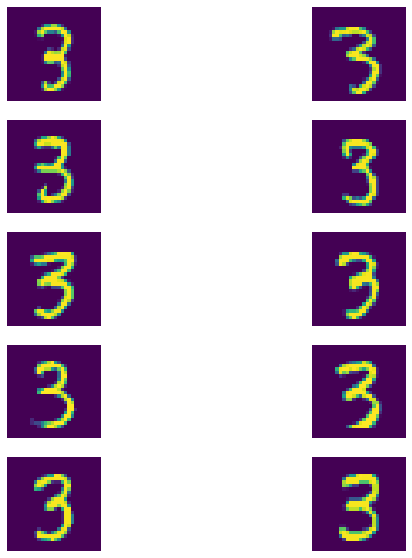

In [72]:
plt.figure(figsize=(10, 10))

for i in range(len(to_show)):
  plt.subplot(5, 2, i+1)
  plt.imshow(np.squeeze(to_show[i]))
  plt.axis('off')